In [1]:
from sqlalchemy import Column,ForeignKey,Integer,String,Float,Table,create_engine,MetaData,inspect,Date
import pandas as pd
import bs4
import urllib
import re
import numpy as np
import random
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib as mpl
import folium

In [10]:
%matplotlib inline
sns.set_style('darkgrid')
engine = create_engine('<postgreSQL URI>')
meta = MetaData()
tls.set_credentials_file(username='<username>',api_key='<api_key>')
sns.set_palette("pastel")

In [3]:
def dbSchema():
    locations = Table(
                        'locations',meta,
                        Column('id',Integer,primary_key=True),
                        Column('city',String(50)),
                        Column('state',String(50)),
                        Column('location_codes_id',Integer,ForeignKey('location_codes.id'))
                     )
    location_codes = Table(
                            'location_codes',meta,
                            Column('id',Integer,primary_key=True),
                            Column('state',String(50)),
                            Column('code',String(50))
                    )
    
        
    customers = Table(
                      'customers',meta,
                      Column('id',Integer,primary_key=True),
                      Column('first_name',String(50)),
                      Column('last_name',String(50)),
                      Column('age',Integer,nullable=False),
                      Column('gender',String(50)),
                      Column('location_id',Integer,ForeignKey('locations.id'),nullable=False),
                 )
    
    salespersons = Table(
                            'salespersons',meta,
                            Column('id',Integer,primary_key=True),
                            Column('first_name',String(50),nullable=False),
                            Column('last_name',String(50),nullable=False),
                            Column('age',Integer,nullable=False),
                            Column('gender',String(50),nullable=False),
                            Column('title',String(50),nullable=False),
                            Column('commission_structure',Float,nullable=False)
                 )
    
    categories = Table(
                        'categories',meta,
                        Column('id',Integer,primary_key=True),
                        Column('category',String(50)),
                        Column('link',String(250))
                     )
    
    products = Table(
                        'products',meta,
                        Column('id',Integer,primary_key=True),
                        Column('name',String(250)),
                        Column('rating',Float),
                        Column('reviews',Integer),
                        Column('price',Float),
                        Column('category_id',Integer,ForeignKey('categories.id')),
                        Column('suppliers_id',Integer,ForeignKey('suppliers.id')),
                        Column('cost_per_unit',Float)
                    )

    suppliers = Table(
                      'suppliers',meta,
                      Column('id',Integer,primary_key=True),
                      Column('name',String(50),nullable=False),
                 )
    
    orders = Table ('orders',meta,
           Column('id',Integer,primary_key=True),
           Column('customer_id',Integer,ForeignKey('customers.id'),nullable=False),
           Column('product_id',Integer,ForeignKey('products.id'),nullable=False),
           Column('quantity',Integer,nullable=False),
           Column('salesperson_id',Integer,ForeignKey('salespersons.id'),nullable=False),
           Column('order_date',Date,nullable=False)
            )

    meta.create_all(engine)
    engine.table_names()
    
def dropTables():
    names = engine.table_names()
    for name in names:
        engine.execute("DROP TABLE {} CASCADE".format(name))
    engine.table_names()
    meta.clear()

In [4]:
def randomCustomers(n):
    lastNames = topLastNames()
    firstNames = topFirstNames()
    customers = []
    for i in range(n):
        firstName = firstNames[np.random.randint(0,len(firstNames))]
        lastName = lastNames[np.random.randint(0,len(lastNames))]
        customers.append([firstName[0],lastName,np.random.randint(18,98),firstName[1]])
    return customers
    
def topFirstNames():    
    results = urllib.request.urlopen('https://www.ssa.gov/oact/babynames/decades/century.html')
    soup = bs4.BeautifulSoup(results)
    rows = soup.find('table',{'class':'t-stripe'}).findAll('tr')
    firstNames= []
    for row in rows[2:101]:
        rowData = row.findAll('td')
        firstNames.append([rowData[1].text,'M'])
        firstNames.append([rowData[3].text,'F'])
    return firstNames

def topLastNames():
        results = urllib.request.urlopen('https://www.rong-chang.com/namesdict/100_last_names.htm')
        soup = bs4.BeautifulSoup(results)
        rows = soup.findAll('a')
        lastNames = []
        for row in rows:
            if row.text !="" and row.text !='Main Menu':
                lastNames.append(row.text)
        return lastNames

In [5]:
def locationsCodesTable():
    requests = urllib.request.urlopen('https://www.ups.com/worldshiphelp/WS12/ENU/AppHelp/Codes/State_Province_Codes.htm')
    soup = bs4.BeautifulSoup(requests)
    table = soup.find('table').find_all('p')
    states_codes = [dict(state=table[i].text.replace(", US",""),code=table[i+1].text) for i in range(2,len(table),2)]
    engine.execute("INSERT INTO location_codes(state,code) VALUES (%(state)s,%(code)s)",states_codes)

def customersTable(n):
    customers=[]
    random_customers = randomCustomers(n)
    location = engine.execute("SELECT ID from locations").fetchall()
    for customer in random_customers:
        customers.append({'first_name':customer[0],'last_name':customer[1],'age':customer[2],'gender':customer[3],'location_id':'{}'.format(*random.choice(location))})
    engine.execute("INSERT INTO customers (first_name,last_name,age,gender,location_id) VALUES (%(first_name)s,%(last_name)s,%(age)s,%(gender)s,%(location_id)s)",customers)
  
def locationsTable():
    locations = []
    results = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population')
    location_codes = pd.read_sql("SELECT id as location_id,state,code as location_code from location_codes",engine)
    location_codes.set_index('state',inplace=True)
    soup = bs4.BeautifulSoup(results,'lxml')
    rows = soup.find('table',{'class':'wikitable sortable'}).findAll('tr')
    locations = []
    for row in rows[1:51]:
            row_data = row.findAll('td')[1:]
            city = re.search('[a-zA-Z]*\s?[a-zA-Z]*',row_data[0].text).group(0).replace('\n','')
            state = re.search('[^\xa0][a-zA-Z]*\s?[a-zA-Z]*\s?[a-zA-Z]*',row_data[1].text).group(0).replace('\n','')
            location_id = int(location_codes.loc[[state]]['location_id'][0])
            locations.append({'city':city,'state':state,'location_codes_id':location_id})
    engine.execute("INSERT INTO locations(city,state,location_codes_id) VALUES (%(city)s,%(state)s,%(location_codes_id)s)",locations)

def productsTable(n):
    links = engine.execute("SELECT id,link from categories").fetchall()
    suppliers = engine.execute("SELECT id from suppliers").fetchall()
    itemNames = []
    for link in links:
        results = urllib.request.urlopen(link[1])
        soup = bs4.BeautifulSoup(results)
        names  = soup.findAll('div',{'class':'p13n-sc-truncate p13n-sc-line-clamp-2'})
        ratings = soup.findAll('span',{'class':'a-icon-alt'})
        reviews = soup.findAll('a',{'class':'a-size-small a-link-normal'})
        prices = soup.findAll('span',{'class':'p13n-sc-price'})
        category_id = link[0]
        for i in range(0,n):
            name = re.sub(r'[^a-zA-Z0-9\s]*','',names[i].text.strip())
            rating = re.search(r'[0-9]*.?[0-9]*\w',ratings[i].text.strip()).group(0)
            review = int(reviews[i].text.replace(",",""))
            price = re.findall(r'[\d.]*',prices[i].text.replace("$",""))
            price = round(np.mean(list(map(float,filter(None,price)))),2)
            supplier_id = random.choice(suppliers)
            cost_per_unit = round(random.randrange(50,95)/100*price,2)
            itemNames.append({'name':name,'rating':rating,'reviews':review,'price':price,'category_id':category_id,'suppliers_id':'{}'.format(*supplier_id),'cost_per_unit':cost_per_unit})
    engine.execute("INSERT INTO products(name,rating,reviews,price,category_id,suppliers_id,cost_per_unit) VALUES (%(name)s,%(rating)s,%(reviews)s,%(price)s,%(category_id)s,%(suppliers_id)s,%(cost_per_unit)s)",itemNames)

def categoriesTable():
    categories =[]
    names = ['toys','electronics','office_products','beauty_personal_care','tools_improvement']
    links=['https://www.amazon.com/Best-Sellers-Toys-Games/zgbs/toys-and-games/ref=zg_bs_nav_0',
           'https://www.amazon.com/Best-Sellers-Electronics/zgbs/electronics/ref=zg_bs_nav_0',
          'https://www.amazon.com/Best-Sellers-Office-Products/zgbs/office-products/ref=zg_bs_nav_0',
          'https://www.amazon.com/Best-Sellers-Beauty/zgbs/beauty/ref=zg_bs_nav_0',
          'https://www.amazon.com/Best-Sellers-Home-Improvement/zgbs/hi/ref=zg_bs_nav_0']
    for i in range(len(names)):
        categories.append({'category':names[i],'link':links[i]})
    engine.execute("INSERT INTO categories(category,link) VALUES(%(category)s,%(link)s)",categories)
        
def salespersonsTable(n):
    names = []
    titles = {'Sales Rep I':1,'Sales Rep II':1.5}
    customers = random.sample(randomCustomers(100),n)
    for customer in customers:
        title = random.choice(list(titles.keys()))
        pay = titles[title]
        names.append({'first_name':customer[0],'last_name':customer[1],'age':customer[2],'gender':customer[3],'title':title,'commission_structure':pay})
    engine.execute("INSERT INTO salespersons (first_name,last_name,age,gender,title,commission_structure) VALUES (%(first_name)s,%(last_name)s,%(age)s,%(gender)s,%(title)s,%(commission_structure)s)",names)
            
def suppliersTable():
    names = []
    suppliers = ['Northeast and Co','Northwest and Co','Southeast and Co','Southwest and Co']
    for supplier in suppliers:
        names.append({'name':supplier})
    engine.execute("INSERT INTO suppliers(name) VALUES (%(name)s)",names)

def ordersTable(n): 
    customer_ids = engine.execute('SELECT id from customers').fetchall()
    product_ids = engine.execute('SELECT id from products').fetchall()
    salesperson_ids= engine.execute('SELECT id from salespersons').fetchall()
    orders = []

    for i in range(0,n):
        customer=random.choice(customer_ids)
        product=random.choice(product_ids)
        q=random.randrange(1,11)
        salesperson=random.choice(salesperson_ids)
        date=datetime.datetime.strftime(datetime.datetime.now()+datetime.timedelta(-random.randrange(0,1095)),'%Y-%m-%d')
        order = {'customer_id':'{}'.format(*customer),'product_id':'{}'.format(*product),'quantity':'{}'.format(q),'salesperson_id':'{}'.format(*salesperson),'order_date':date}
        orders.append(order)
    engine.execute("INSERT INTO orders (customer_id, product_id, quantity, salesperson_id, order_date) VALUES (%(customer_id)s, %(product_id)s, %(quantity)s,%(salesperson_id)s,%(order_date)s)",orders)

In [6]:
start_time = time.time()
dropTables()
dbSchema()
locationsCodesTable()
locationsTable()
customersTable(400)
categoriesTable()
suppliersTable()
productsTable(20)
salespersonsTable(10)
ordersTable(8000)
time_diff = time.time() - start_time
print("{} minute(s) and {} seconds.".format(int(time_diff//60),round(time_diff%60,2)))

5 minute(s) and 53.99 seconds.


In [7]:
sql_query = '''
                with calcTable AS (
                    SELECT
                        o.id AS id,
                        p.price - p.cost_per_unit - sp.commission_structure AS net_margin,
                        p.price * o.quantity AS total_revenue,
                        p.cost_per_unit * o.quantity AS total_cost
                    FROM orders o
                    JOIN products p on p.id = o.product_id
                    JOIN salespersons sp on sp.id = o.salesperson_id
                )
                SELECT 
                    c.first_name AS customer_fname,
                    c.last_name AS customer_lname,
                    c.age AS customer_age,
                    c.gender As customer_gender,
                    p.name AS product_name,
                    p.rating AS product_rating,
                    p.reviews AS product_reviews,
                    p.price AS product_price,
                    o.quantity AS order_quantity,
                    o.order_date AS order_date,
                    p.cost_per_unit AS product_cost_per_unit,
                    sales.first_name AS salesperson_fname,
                    sales.last_name AS salesperson_lname,
                    sales.age AS salesperson_age,
                    sales.gender AS salesperson_gender,
                    sales.title AS salesperson_title,
                    sales.commission_structure AS salesperson_commission_structure,
                    cat.category AS categories,
                    supp.name AS supplier_name,
                    cte.net_margin AS net_margin,
                    cte.total_revenue AS total_revenue,
                    cte.total_cost AS total_cost,
                    cte.net_margin * o.quantity AS net_profit,
                    l.state AS state,
                    lc.code AS location_code
                FROM orders o
                JOIN customers c on c.id = o.customer_id
                JOIN products p on p.id = o.product_id
                JOIN salespersons sales on sales.id = o.salesperson_id
                JOIN categories cat on cat.id = p.category_id
                JOIN suppliers supp on supp.id = p.suppliers_id
                JOIN locations l on l.id = c.location_id
                JOIN location_codes lc on lc.id = l.location_codes_id
                JOIN calcTable cte on cte.id = o.id
            '''

In [8]:
df = pd.read_sql(sql_query,engine,parse_dates=['order_date'])
display(df.describe())
display(df.dtypes)

,customer_age,product_rating,product_reviews,product_price,order_quantity,product_cost_per_unit,salesperson_age,salesperson_commission_structure,net_margin,total_revenue,total_cost,net_profit
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,56.934750,4.285000,5316.829500,30.103036,5.506625,21.436249,51.120750,1.298938,7.367850,166.264450,118.428601,40.693974
std,22.776327,0.301042,8400.608286,29.661070,2.874368,21.513315,24.843587,0.245179,9.725553,205.054677,147.792057,65.108399
min,18.000000,3.400000,4.000000,1.690000,1.000000,1.320000,23.000000,1.000000,-1.130000,1.690000,1.320000,-11.300000
25%,37.000000,4.100000,1130.000000,11.370000,3.000000,8.020000,27.000000,1.000000,1.730000,46.450000,31.990000,5.580000
50%,55.000000,4.300000,2306.000000,19.990000,6.000000,14.710000,43.000000,1.500000,4.190000,99.950000,71.330000,19.800000
75%,76.000000,4.500000,5085.000000,39.940000,8.000000,28.230000,82.000000,1.500000,10.490000,209.940000,149.030000,52.000000
max,97.000000,4.800000,43896.000000,199.000000,10.000000,128.790000,90.000000,1.500000,74.620000,1990.000000,1287.900000,746.200000


customer_fname                              object
customer_lname                              object
customer_age                                 int64
customer_gender                             object
product_name                                object
product_rating                             float64
product_reviews                              int64
product_price                              float64
order_quantity                               int64
order_date                          datetime64[ns]
product_cost_per_unit                      float64
salesperson_fname                           object
salesperson_lname                           object
salesperson_age                              int64
salesperson_gender                          object
salesperson_title                           object
salesperson_commission_structure           float64
categories                                  object
supplier_name                               object
net_margin                     

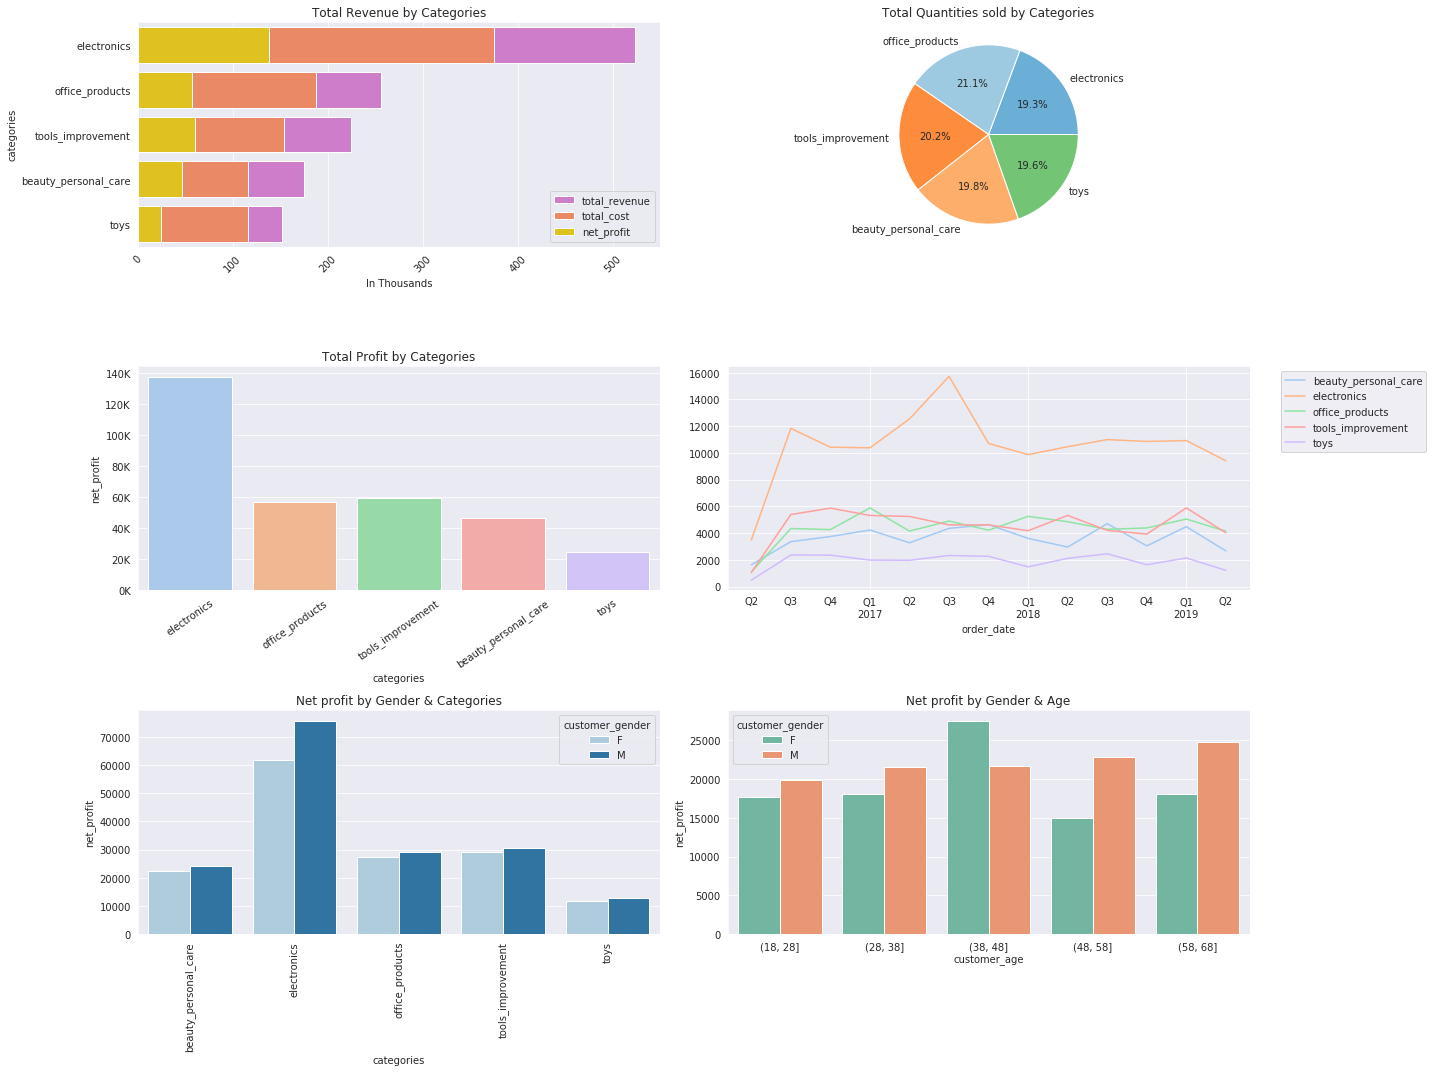

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [13]:
revenue_by_categories = df.groupby('categories').sum().sort_values('total_revenue',ascending=False).reset_index()
colors = plt.get_cmap("tab20c")(np.array([1, 2, 5, 6, 9]))
plt.figure(figsize=(20,15))

ax = plt.subplot(321)
sns.barplot(x="total_revenue",y="categories",data=revenue_by_categories,color='orchid',ci=None)
sns.barplot(x="total_cost",y="categories",data=revenue_by_categories,color='coral',ci=None)
sns.barplot(x="net_profit",y="categories",data=revenue_by_categories,color='gold',ci=None)
plt.xticks(rotation='45')
plt.legend(['total_revenue','total_cost','net_profit'])
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000)))
ax.set_xlabel('In Thousands')
plt.title("Total Revenue by Categories")

plt.subplot(322)
plt.pie(revenue_by_categories['order_quantity'],colors=colors,labels=revenue_by_categories.categories,autopct='%1.1f%%')
plt.title('Total Quantities sold by Categories')

ax = plt.subplot(323)
sns.barplot(x='categories',y='net_profit',data=revenue_by_categories)
plt.title('Total Profit by Categories')
plt.xticks(rotation='35')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos:'{:,.0f}'.format(x/1000) + 'K'))

ax = plt.subplot(324)
summary = df.groupby(['categories','order_date']).sum().reset_index()
summary.set_index('order_date',inplace=True)
summary=summary[['categories','net_profit']].pivot(columns='categories',values='net_profit')
summary.fillna(0,inplace=True)
summary_resample = summary.resample('Q').sum()
summary_resample.plot(ax=ax)
plt.legend(loc=2,bbox_to_anchor=(1.05, 1.0))

plt.subplot(3,2,5)
gender_summary = df[['customer_gender','categories','net_profit']].groupby(['customer_gender','categories']).sum().reset_index()
gender_summary[['categories','customer_gender']] = gender_summary[['categories','customer_gender']].astype('category')
ax = sns.barplot(x='categories',y='net_profit',hue='customer_gender',data=gender_summary,palette='Paired')
plt.title('Net profit by Gender & Categories')
plt.xticks(rotation=90)

plt.subplot(3,2,6)
customer_age = df[['customer_age','net_profit','customer_gender']]
customer_age = customer_age.groupby([pd.cut(customer_age['customer_age'],bins=[18,28,38,48,58,68]),'customer_gender']).sum()
customer_age['customer_age'] = customer_age.index
customer_age.reset_index(level=1,inplace=True)
customer_age['customer_age'] = customer_age.index
customer_age.reset_index(inplace=True,drop=True)
customer_age['customer_gender'] = customer_age['customer_gender'].astype('category')
sns.barplot(x='customer_age',y='net_profit',hue='customer_gender',data=customer_age,palette="Set2")
plt.title('Net profit by Gender & Age')

plt.tight_layout()
plt.show()

summary_by_state = df.groupby(['location_code','categories']).sum().reset_index()
summary_by_state.set_index('location_code',inplace=True)
summary_by_state = summary_by_state[['categories','net_profit']].pivot(columns='categories',values='net_profit')
summary_by_state.reset_index(inplace=True)
summary_by_state.fillna(0.00,inplace=True)
summary_by_state['text'] = 'beauty_personal_care:' +summary_by_state['beauty_personal_care'].round(2).astype(str) + ' electronics:'+summary_by_state['electronics'].round(2).astype(str)+'<br>'+\
    'office_product:'+summary_by_state['office_products'].round(2).astype(str) + ' tools_improvement:' +summary_by_state['tools_improvement'].round(2).astype(str) +'<br>' +\
    'toy:' + summary_by_state['toys'].round(2).astype(str)
summary_by_state['net_profit'] = summary_by_state['beauty_personal_care'] + summary_by_state['electronics'] + summary_by_state['office_products'] + summary_by_state['tools_improvement'] + summary_by_state['toys']
data = [dict(type='choropleth',autocolorscale=False,text=summary_by_state['text'],locations=summary_by_state['location_code'],z=summary_by_state['net_profit'],locationmode='USA-states',colorbar=dict(title='Net Profit in thousands'))]
layout = dict(title='Net profit by state',geo=dict(scope='usa'))
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='d3choroplethmap.html')